# Control Model Trained from Scratch
This file is used to train a basic CNN model from scratch on the adapted cars dataset (49 classes, images cropped around the bounding boxes, and 50% more training data).

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.applications.vgg16 import VGG16

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat

In [3]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# devkit_path = Path('/Users/andrewlee/Desktop/645_Final/devkit')
train_path = '/content/gdrive/MyDrive/Kaggle/data/car_data/train/'
test_path = '/content/gdrive/MyDrive/Kaggle/data/car_data/test/'

In [5]:

gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.25}

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

test_params = {"rescale":1.0/255,}
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**test_params)


## Data generator for training images
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/train/',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='training')

val_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/train/',
                                                    class_mode='categorical', batch_size = 32, 
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='validation')

test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/test/',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True)

Found 9138 images belonging to 49 classes.
Found 3021 images belonging to 49 classes.
Found 4026 images belonging to 49 classes.


In [6]:

from collections import Counter
train = Counter(train_generator.classes)
val = Counter(val_generator.classes)
test = Counter(test_generator.classes)
total = dict(train+val+test)
class_names = dict(train_generator.class_indices)
class_names = {v: k for k, v in class_names.items()}

In [7]:
class_df = pd.DataFrame([class_names,total]).transpose()
class_df.columns=['Make','Num Images']
class_df


,Make,Num Images
0,AM General,89
1,Acura,482
2,Aston Martin,314
3,Audi,1169
4,BMW,1055
5,Bentley,472
6,Bugatti,152
7,Buick,314
8,Cadillac,257
9,Chevrolet,1799


In [8]:
def my_model_cnn(ishape = (224,224,3),k = 49, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    l1 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(model_input)
    l2 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(l1)
    l2_drop = tf.keras.layers.Dropout(0.25)(l2)
    l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)
    l4 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l3)
    l5 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l4)
    l5_drop = tf.keras.layers.Dropout(0.25)(l5)
    flat = tf.keras.layers.Flatten()(l5_drop)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(flat)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [9]:
model2 = my_model_cnn()
print(model2.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 48)      1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 48)      20784     
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 48)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 48)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 96)      41568     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 96)      83040 

In [10]:
model_name = "enel_645_team_14_projectB.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [11]:
batch = 128
num_epochs = 100

history = model2.fit(train_generator,
                    validation_data = val_generator,
                    epochs=num_epochs,
                    verbose=1,
                    batch_size=batch,
                    callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
286/286 [==============================] - 2977s 10s/step - loss: 3.5975 - accuracy: 0.0998 - val_loss: 3.3574 - val_accuracy: 0.1076
Epoch 2/100
286/286 [==============================] - 193s 674ms/step - loss: 3.2860 - accuracy: 0.1265 - val_loss: 3.2236 - val_accuracy: 0.1397
Epoch 3/100
286/286 [==============================] - 193s 674ms/step - loss: 3.1610 - accuracy: 0.1465 - val_loss: 3.1359 - val_accuracy: 0.1609
Epoch 4/100
286/286 [==============================] - 194s 678ms/step - loss: 3.0567 - accuracy: 0.1768 - val_loss: 3.0611 - val_accuracy: 0.1791
Epoch 5/100
286/286 [==============================] - 194s 678ms/step - loss: 2.9412 - accuracy: 0.1913 - val_loss: 3.0500 - val_accuracy: 0.1867
Epoch 6/100
286/286 [==============================] - 192s 669ms/step - loss: 2.8561 - accuracy: 0.2246 - val_loss: 2.9469 - val_accuracy: 0.2003
Epoch 7/100
286/286 [==============================] - 189s 662ms/step - loss: 2.7688 - accuracy: 0.2287 - val_loss: 2.

In [12]:
model2.load_weights(model_name)
metrics = model2.evaluate(test_generator)

126/126 [==============================] - 937s 7s/step - loss: 2.7874 - accuracy: 0.2688


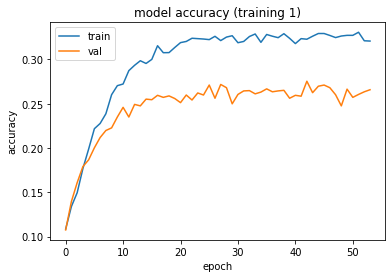

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy (training 1)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:

max(history.history['val_accuracy'])

0.27540549635887146

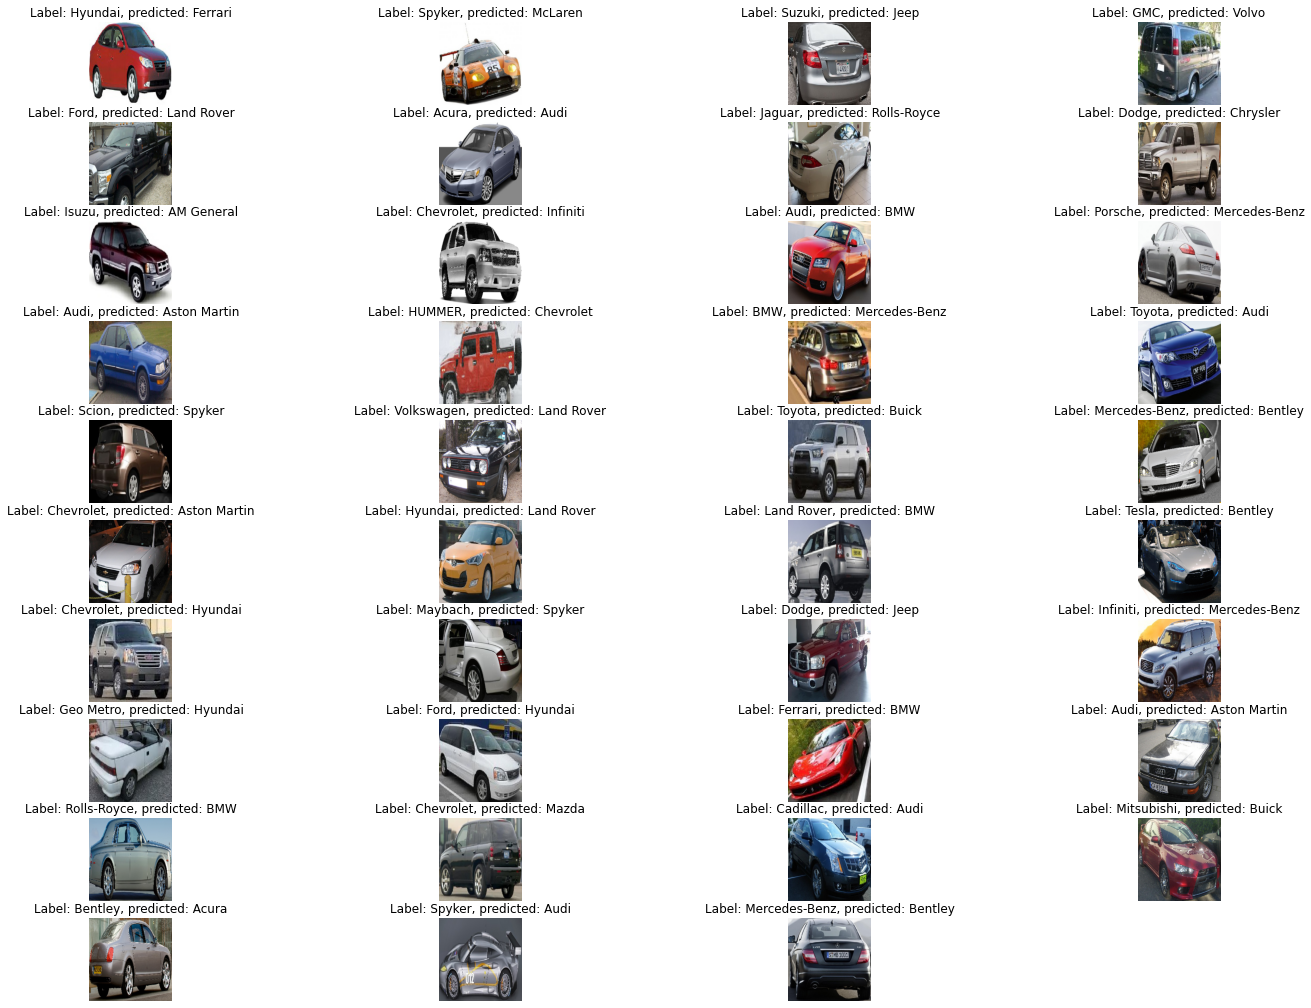

In [19]:
img = []
true_label = []
pred_label = []
for ii in range(2):
    Xbatch,Ybatch = test_generator.__getitem__(ii)
    Ybatch = Ybatch.argmax(axis = 1)
    Ypred = model2.predict(Xbatch).argmax(axis = 1)
    wrong_indexes = np.where(Ypred != Ybatch)[0]
    for ii in wrong_indexes:
        img.append(Xbatch[ii])
        true_label.append(Ybatch[ii])
        pred_label.append(Ypred[ii])

columns = 4
rows = len(img)//columns + 1    
plt.figure(figsize = (24,18))
for ii in range(len(img)):
    plt.subplot(rows,columns,ii+1)
    plt.imshow(img[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Label: %s, predicted: %s" %(class_names[true_label[ii]]\
                                            ,class_names[pred_label[ii]]))
plt.show()